In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(color_codes=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.1


## Load the data

In [3]:
df = pd.read_csv('../cleaned_data/TLKM.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,-1.257411,-1.265240,-1.272727,-0.808345,0.491269,0.706085,0.927517,0.696955,1.053230,1.012777,0.0,0.5,0.5,-1.0,0.594005,0.066667,0.592593,-1.248980
2012-10-18,-1.253889,-1.260517,-1.269972,-0.830223,-0.014190,0.278954,0.557617,0.054518,0.628572,0.633022,0.5,0.5,0.5,-1.0,0.599455,0.133333,0.592593,-1.265306
2012-10-19,-1.253889,-1.258155,-1.268005,-0.830223,-0.014190,0.278954,0.557617,0.319828,0.968469,0.918278,1.0,0.5,0.5,-1.0,0.604905,0.200000,0.592593,-1.265306
2012-10-22,-1.253889,-1.255203,-1.266037,-0.830223,-0.491719,-0.129789,0.200645,-0.324491,0.591624,0.640169,-1.0,0.5,0.5,-1.0,0.621253,0.400000,0.629630,-1.281633
2012-10-23,-1.258585,-1.254613,-1.264856,-0.760737,0.022975,0.231437,0.483864,-0.324491,0.429086,0.803149,-0.5,0.5,0.5,-1.0,0.626703,0.466667,0.629630,-1.265306


### Plot the Close price - our target

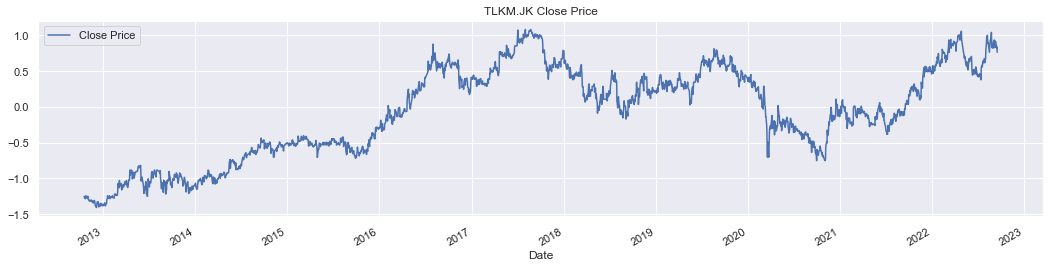

In [4]:
df['Close'].plot(figsize=(18,4))
plt.legend(['Close Price'])
plt.title('TLKM.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [5]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Modeling

### Regression with Deep Neural Network

In [7]:
from utils import build_and_compile_model, fit_model

In [8]:
from utils import genPredictions, inversePredsAndAct, evaluateModel

In [9]:
from joblib import load

close_scaler = load('../feature_engineering/tlkm_close_scaler.bin')

In [10]:
epochs_cands = [100,150,200]
batch_size_cands = [32,64,128]
performances = {}
models = {}
predictions_dfs = {}
inversed_dfs = {}

modelID = 1
for epochs in epochs_cands:
    for batch_size in batch_size_cands:
        print(f'\n==========MODEL {modelID} with epochs: {epochs} and batch size: {batch_size}==========')
        model = build_and_compile_model(17)
        history = fit_model(model, epochs, batch_size, train_features, train_labels)
        models[f'Model-{modelID}'] = (model, history)
        predictions = genPredictions(model, df, test_features, train_len)
        predictions_dfs[f'Model-{modelID}'] = predictions
        
        inversed = inversePredsAndAct(predictions, close_scaler, test_labels)
        inversed_dfs[f'Model-{modelID}'] = inversed
        rmse_, mape_, rsquared_ = evaluateModel(inversed)
        performances[f'Model-{modelID}'] = {
            'Epochs': epochs,
            'Batch Size': batch_size,
            'RMSE': rmse_,
            'MAPE': mape_,
            'R2': rsquared_
        }
        
        modelID += 1
        


==========MODEL 1 with epochs: 100 and batch size: 32==========
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 1ms/step

==========MODEL 2 with epochs: 100 and batch size: 64==========
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape 

Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 1ms/step


In [11]:
performance_df = pd.DataFrame(performances).transpose()
performance_df[['Epochs', 'Batch Size']] = performance_df[['Epochs', 'Batch Size']].astype(int)
performance_df.head(9)

,Epochs,Batch Size,RMSE,MAPE,R2
Model-1,100,32,79.659012,1.749746,0.980295
Model-2,100,64,113.974372,2.749450,0.959662
Model-3,100,128,76.513549,1.694367,0.981821
Model-4,150,32,77.829051,1.732125,0.981190
Model-5,150,64,98.163897,2.257898,0.970077
Model-6,150,128,95.302395,2.197344,0.971796
Model-7,200,32,88.034838,2.112024,0.975933
Model-8,200,64,94.607622,2.155326,0.972206
Model-9,200,128,106.622259,2.528609,0.964698


### Plot the best model

In [13]:
from utils import plotPredAct, plotErrorHist

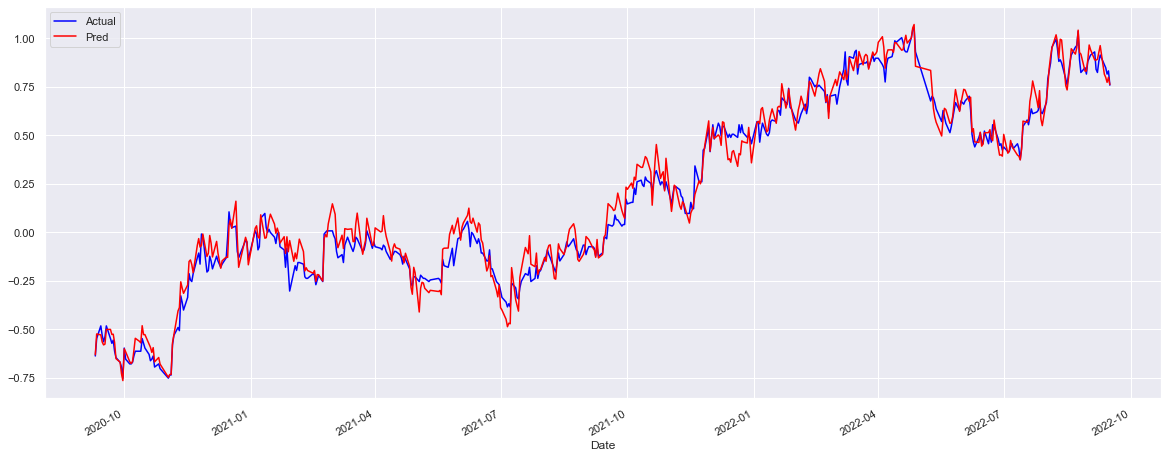

In [14]:
plotPredAct(predictions_dfs['Model-3'])

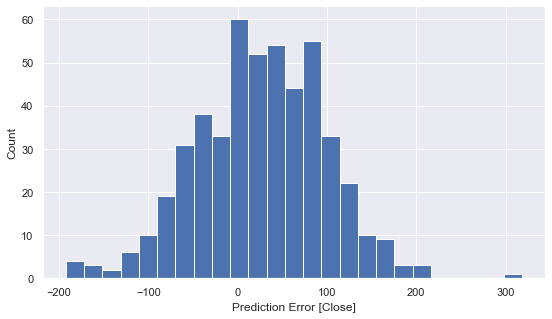

In [15]:
plt.figure(figsize=(9,5))
plotErrorHist(inversed_dfs['Model-3'])

### Save the best model

In [16]:
models['Model-3'][0].save('./models/tlkm.h5')

In [17]:
loadedModel = keras.models.load_model('./models/tlkm.h5')

In [18]:
loadedModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1152      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
